<a href="https://colab.research.google.com/github/efemeryczny/network_analysis/blob/main/stock_market_indices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
csv_files = {
    'djusbk': '/content/drive/MyDrive/Colab Notebooks/stock_market/DJUSBK.csv',
    'euro': '/content/drive/MyDrive/Colab Notebooks/stock_market/euro.csv',
    'wigbanki': '/content/drive/MyDrive/Colab Notebooks/stock_market/wigbanki.csv'
}

In [19]:
wigbanki = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stock_market/wigbanki.csv')
wigbanki.rename(columns={'Zamkniecie': 'Close'}, inplace=True)
wigbanki

,Data,Otwarcie,Najwyzszy,Najnizszy,Close,Wolumen
0,1991-04-16,100.00,100.00,100.00,100.00,35.0
1,1991-04-23,96.77,96.77,96.77,96.77,630.0
2,1991-04-30,94.56,94.56,94.56,94.56,764.0
3,1991-05-14,93.96,93.96,93.96,93.96,1952.0
4,1991-05-21,96.61,96.61,96.61,96.61,1573.0
...,...,...,...,...,...,...
7580,2023-05-25,7131.93,7259.66,7077.07,7204.33,3355354.0
7581,2023-05-26,7223.53,7357.07,7197.84,7349.04,5152298.0
7582,2023-05-29,7374.96,7378.36,7286.70,7335.93,2116403.0
7583,2023-05-30,7289.84,7293.94,7177.40,7181.76,3155805.0


In [25]:
djusbk = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stock_market/DJUSBK.csv')
djusbk.rename(columns={'Date':'Data'}, inplace=True)
djusbk

,Data,Open,High,Low,Close
0,05/30/2023,398.35,398.35,398.35,398.35
1,05/25/2023,394.85,394.85,394.85,394.85
2,05/24/2023,395.19,395.19,395.19,395.19
3,05/23/2023,400.74,400.74,400.74,400.74
4,05/22/2023,400.29,400.29,400.29,400.29
...,...,...,...,...,...
238,06/06/2022,496.13,496.13,496.13,496.13
239,06/03/2022,495.37,495.37,495.37,495.37
240,06/02/2022,502.14,502.14,502.14,502.14
241,06/01/2022,496.22,496.22,496.22,496.22


In [23]:
euro = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stock_market/euro.csv')
euro.rename(columns={'Date':'Data'}, inplace=True)
euro

,Data,Open,High,Low,Close
0,05/31/2023,"7,371.48","7,371.48","7,371.48","7,371.48"
1,05/30/2023,"7,142.98","7,142.98","7,142.98","7,142.98"
2,05/29/2023,"6,984.22","6,984.22","6,984.22","6,984.22"
3,05/26/2023,"6,919.21","6,919.21","6,919.21","6,919.21"
4,05/25/2023,"7,004.93","7,004.93","7,004.93","7,004.93"
...,...,...,...,...,...
247,06/06/2022,"10,298.60","10,298.60","10,298.60","10,298.60"
248,06/03/2022,"10,650.10","10,650.10","10,650.10","10,650.10"
249,06/02/2022,"10,551.06","10,551.06","10,551.06","10,551.06"
250,06/01/2022,"10,557.07","10,557.07","10,557.07","10,557.07"


Number of nodes: 3
Number of edges: 0
Average clustering coefficient: 0.0


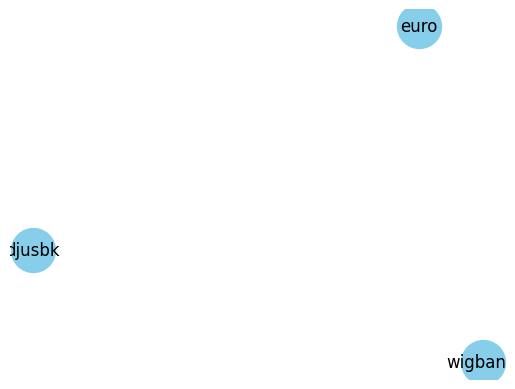

In [29]:
# Merge the dataframes on 'Data' column to align the dates
merged_df = wigbanki[['Data', 'Close']].merge(djusbk[['Data', 'Close']], on='Data', how='inner')
merged_df = merged_df.merge(euro[['Data', 'Close']], on='Data', how='inner')

# Extract the aligned price series from the merged dataframe
wigbanki_prices = merged_df['Close_x'].values
djusbk_prices = merged_df['Close_y'].values
euro_prices = merged_df['Close'].values

# Store the data in a dictionary
index_data = {
    'wigbanki': wigbanki_prices,
    'djusbk': djusbk_prices,
    'euro': euro_prices
}

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for index in index_data:
    G.add_node(index)

# Calculate correlation matrix between indices
valid_indices = [index for index in index_data if len(index_data[index]) > 0]
corr_matrix = np.zeros((len(valid_indices), len(valid_indices)))

for i in range(len(valid_indices)):
    for j in range(i + 1, len(valid_indices)):
        index1 = valid_indices[i]
        index2 = valid_indices[j]
        prices1 = index_data[index1]
        prices2 = index_data[index2]
        common_dates = set(prices1.keys()).intersection(set(prices2.keys()))
        prices1_common = [prices1[date] for date in common_dates]
        prices2_common = [prices2[date] for date in common_dates]
        corr_value = np.corrcoef(prices1_common, prices2_common)[0, 1]
        corr_matrix[i, j] = corr_value
        corr_matrix[j, i] = corr_value

# Add edges to the graph based on correlation values
for i in range(len(valid_indices)):
    for j in range(i + 1, len(valid_indices)):
        corr_value = corr_matrix[i, j]
        G.add_edge(valid_indices[i], valid_indices[j], weight=corr_value)

# Analyze the network
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average clustering coefficient:", nx.average_clustering(G))

# Visualization
pos = nx.spring_layout(G)  # Layout for visualizing the graph
weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]
nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', node_size=1000,
                 edge_color='gray', width=weights)
plt.axis('off')
plt.show()